# Week 4: Multi-class Classification

In [35]:
# grader-required-cell
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets (the test set will actually be used as a validation set):

In [36]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 248MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 170MB/s]


Define some globals with the path to both files you just downloaded:

In [37]:
# grader-required-cell

TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [38]:
# grader-required-cell

with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

As you can see, each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values.

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

 ## Parsing the dataset

In [51]:
import numpy as np
import csv

def parse_data_from_input(filename):
    """
    Parses the images and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        images, labels: tuple of numpy arrays containing the images and labels
    """
    with open(filename) as file:
        csv_reader = csv.reader(file, delimiter=',')
        next(csv_reader)  # Skip the header line

        images = []
        labels = []

        for row in csv_reader:
            labels.append(int(row[0]))
            images.append([int(x) for x in row[1:]])

    images = np.array(images, dtype=np.float64)
    labels = np.array(labels, dtype=np.float64)

    # Reshape images to (num_samples, 28, 28)
    images = np.reshape(images, (images.shape[0], 28, 28))

    return images, labels


In [52]:
# grader-required-cell

# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays

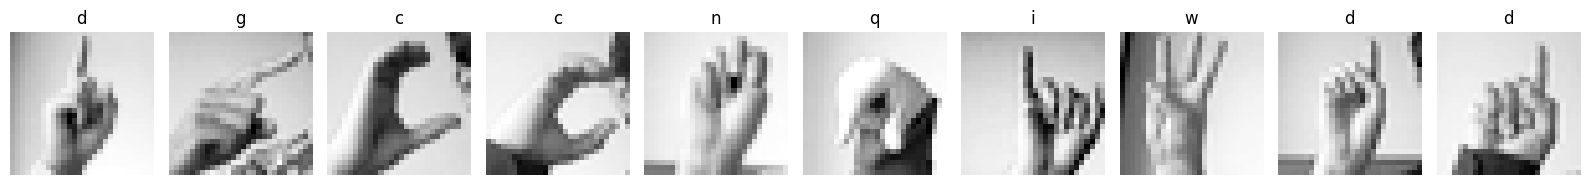

In [53]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    """
    Creates the training and validation data generators

    Args:
        training_images (array): parsed images from the train CSV file
        training_labels (array): parsed labels from the train CSV file
        validation_images (array): parsed images from the test CSV file
        validation_labels (array): parsed labels from the test CSV file

    Returns:
        train_generator, validation_generator - tuple containing the generators
    """
    ### START CODE HERE

    # Add another dimension to the data using np.expand_dims
    training_images = np.expand_dims(training_images, axis=-1)
    validation_images = np.expand_dims(validation_images, axis=-1)

    # Instantiate the ImageDataGenerator class for training data
    # Normalize pixel values by dividing by 255
    # You can also apply data augmentation techniques if desired
    train_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Pass in the appropriate arguments to the flow method
    train_generator = train_datagen.flow(x=training_images,
                                         y=training_labels,
                                         batch_size=32)

    # Instantiate the ImageDataGenerator class for validation data
    # Normalize pixel values by dividing by 255
    validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Pass in the appropriate arguments to the flow method
    validation_generator = validation_datagen.flow(x=validation_images,
                                                   y=validation_labels,
                                                   batch_size=32)

    ### END CODE HERE

    return train_generator, validation_generator


In [55]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model():
    """
    Creates a Keras model for image classification

    Returns:
        model: the compiled Keras model
    """
    ### START CODE HERE

    # Define the model using Sequential API
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(25, activation='softmax'))  # Assuming there are 25 categories

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    ### END CODE HERE

    return model


In [57]:
# Save your model
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 9s 8ms/step - loss: 0.6452 - accuracy: 0.8097 - val_loss: 0.3737 - val_accuracy: 0.8866
Epoch 2/15
858/858 [==============================] - 5s 6ms/step - loss: 0.0179 - accuracy: 0.9967 - val_loss: 0.4808 - val_accuracy: 0.8868
Epoch 3/15
858/858 [==============================] - 5s 6ms/step - loss: 0.0134 - accuracy: 0.9972 - val_loss: 0.3269 - val_accuracy: 0.9137
Epoch 4/15
858/858 [==============================] - 5s 6ms/step - loss: 4.4069e-04 - accuracy: 1.0000 - val_loss: 0.3449 - val_accuracy: 0.9177
Epoch 5/15
858/858 [==============================] - 5s 6ms/step - loss: 2.5787e-04 - accuracy: 1.0000 - val_loss: 0.3634 - val_accuracy: 0.9169
Epoch 6/15
858/858 [==============================] - 5s 6ms/step - loss: 0.0329 - accuracy: 0.9902 - val_loss: 0.3352 - val_accuracy: 0.9123
Epoch 7/15
858/858 [==============================] - 5s 5ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.3336 - val_accuracy: 0.925

Now take a look at your training history:

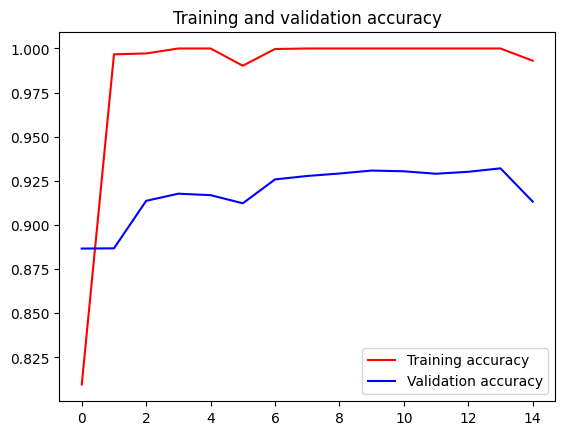

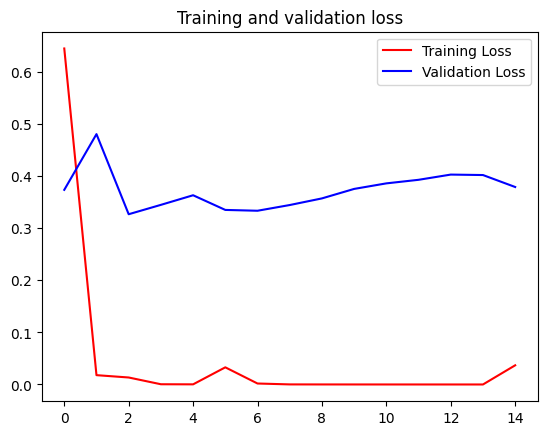

In [58]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()